In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time


In [2]:
dfi = pd.read_csv('./Data/Weather_NY.csv')
dfi

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,...,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,2016-12-31 19:51:00,6.1,43.0,-4.4,24.1,47.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10477,2016-12-31 20:51:00,6.1,43.0,-4.4,24.1,47.0,13.0,8.1,38.9,24.2,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10478,2016-12-31 21:51:00,6.1,43.0,-5.0,23.0,45.0,9.3,5.8,29.6,18.4,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10479,2016-12-31 22:51:00,6.7,44.1,-5.0,23.0,43.0,14.8,9.2,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [3]:
df = dfi.loc[dfi['pickup_datetime'] > '2016-08-01']
df

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
6122,2016-08-01 00:51:00,3.0,37.4,-6.0,21.2,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Unknown,unknown,0,0,0,0,0,0
6123,2016-08-01 01:51:00,3.0,37.4,-6.0,21.2,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Unknown,unknown,0,0,0,0,0,0
6124,2016-08-01 02:51:00,3.0,37.4,-6.0,21.2,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Unknown,unknown,0,0,0,0,0,0
6125,2016-08-01 03:51:00,2.0,35.6,-7.0,19.4,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Unknown,unknown,0,0,0,0,0,0
6126,2016-08-01 04:51:00,2.0,35.6,-8.0,17.6,48.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Unknown,unknown,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,2016-12-31 19:51:00,6.1,43.0,-4.4,24.1,47.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10477,2016-12-31 20:51:00,6.1,43.0,-4.4,24.1,47.0,13.0,8.1,38.9,24.2,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10478,2016-12-31 21:51:00,6.1,43.0,-5.0,23.0,45.0,9.3,5.8,29.6,18.4,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10479,2016-12-31 22:51:00,6.7,44.1,-5.0,23.0,43.0,14.8,9.2,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [4]:
df = df[['pressurem','tempm','hum','dewptm']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,pressurem,tempm,hum,dewptm
0,1022.2,6.1,62.0,-0.6
1,1021.6,6.1,62.0,-0.6
2,1021.7,6.1,68.0,0.6
3,1021.5,6.7,65.0,0.6
4,1022.6,6.7,65.0,0.6
...,...,...,...,...
4240,1013.8,6.1,47.0,-4.4
4241,1012.9,6.1,47.0,-4.4
4242,1012.5,6.1,45.0,-5.0
4243,1012.4,6.7,43.0,-5.0


In [5]:
df['nxt_target'] = df['dewptm'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pressurem   4245 non-null   float64
 1   tempm       4245 non-null   float64
 2   hum         4245 non-null   float64
 3   dewptm      4245 non-null   float64
 4   nxt_target  4245 non-null   float64
dtypes: float64(5)
memory usage: 165.9 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,pressurem,tempm,hum,dewptm,nxt_target
0,1022.2,6.1,62.0,-0.6,-0.6
1,1021.6,6.1,62.0,-0.6,0.6
2,1021.7,6.1,68.0,0.6,0.6
3,1021.5,6.7,65.0,0.6,0.6
4,1022.6,6.7,65.0,0.6,1.0
...,...,...,...,...,...
3391,1015.3,-1.7,47.0,-11.7,-10.0
3392,1014.1,0.6,46.0,-10.0,-7.2
3393,1012.8,3.3,47.0,-7.2,-8.9
3394,1010.3,4.4,38.0,-8.9,-7.8


In [8]:
train.iloc[:,-1:]

,nxt_target
0,-0.6
1,0.6
2,0.6
3,0.6
4,1.0
...,...
3391,-10.0
3392,-7.2
3393,-8.9
3394,-7.8


In [9]:
train.iloc[:,:4]

,pressurem,tempm,hum,dewptm
0,1022.2,6.1,62.0,-0.6
1,1021.6,6.1,62.0,-0.6
2,1021.7,6.1,68.0,0.6
3,1021.5,6.7,65.0,0.6
4,1022.6,6.7,65.0,0.6
...,...,...,...,...
3391,1015.3,-1.7,47.0,-11.7
3392,1014.1,0.6,46.0,-10.0
3393,1012.8,3.3,47.0,-7.2
3394,1010.3,4.4,38.0,-8.9


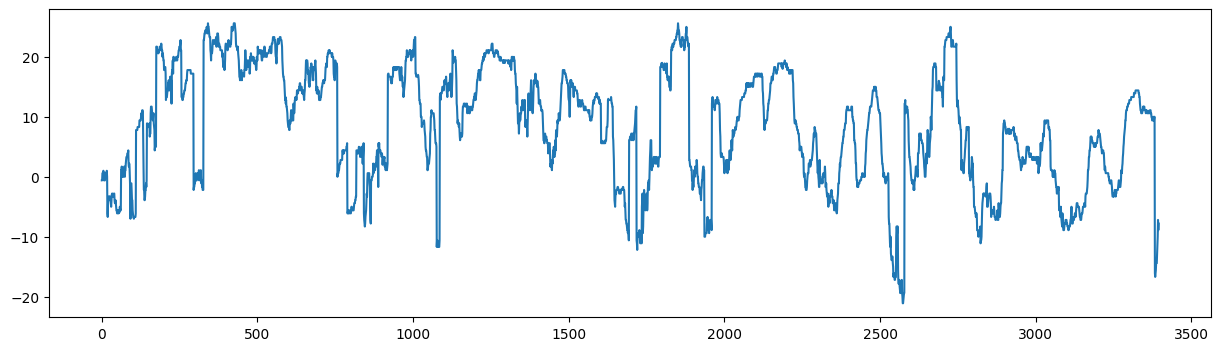

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["dewptm"])
plt.show()

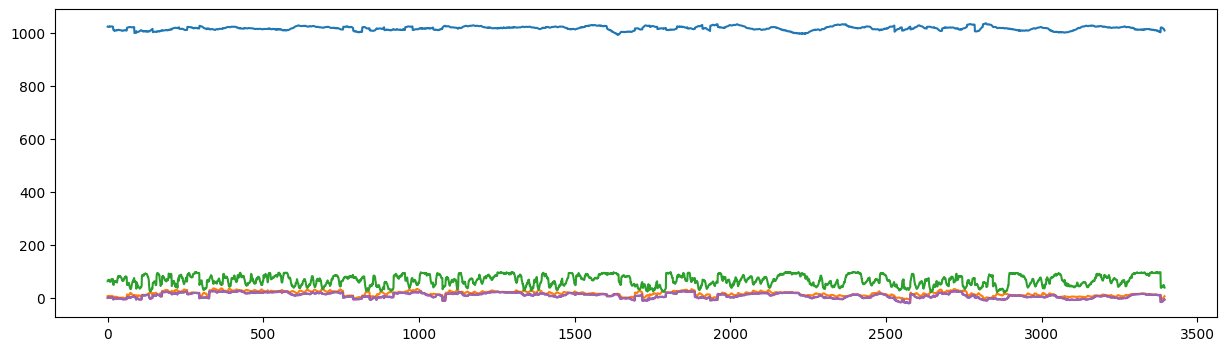

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3386, 10, 4])


tensor([ 0.8510, -1.1124, -0.1688, -0.9479])

In [17]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            bidirectional=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers *2 , batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=4, hidden_units= 12)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [19]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:107.11592127113545 
[2/5]  LossQ:62.40723770641307 
[3/5]  LossQ:60.33633141435166 
[4/5]  LossQ:59.64346540247789 
[5/5]  LossQ:59.40403578211408 


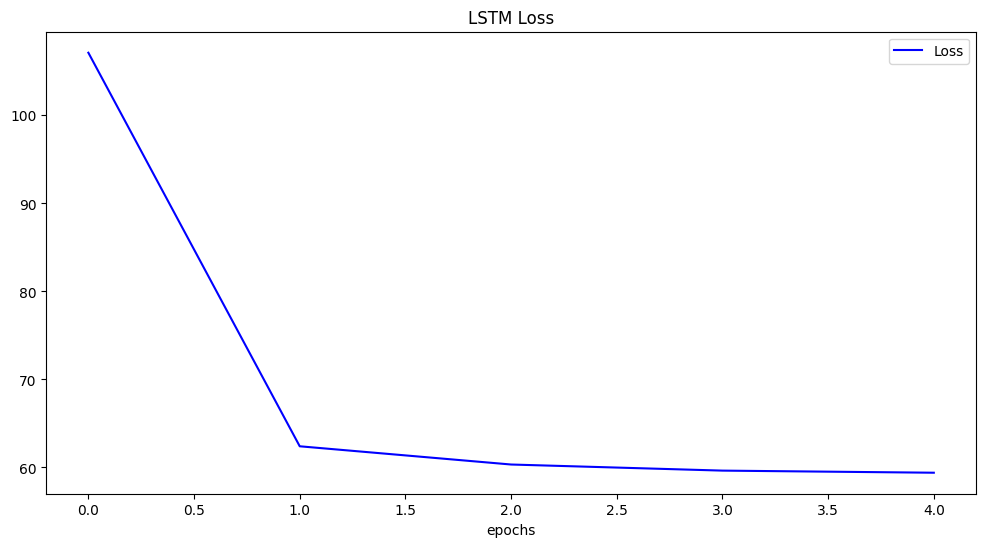

In [20]:
np.savetxt('./SavedModels/NY/loss/cblstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [21]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.7077, -0.7068, -0.6438,  ..., -1.7757, -1.5322, -1.7544],
       grad_fn=<ViewBackward0>)


In [22]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [23]:
pred_y_train

tensor([[-0.7077],
        [-0.7068],
        [-0.6438],
        ...,
        [-1.7757],
        [-1.5322],
        [-1.7544]], grad_fn=<ViewBackward0>)

In [24]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [25]:
np.savetxt('./SavedModels/NY/train/cblstm.txt',y_train_pred)
np.savetxt('./SavedModels/NY/test/cblstm.txt',y_test_pred)

Training dataset RMSE:3.200186932093187


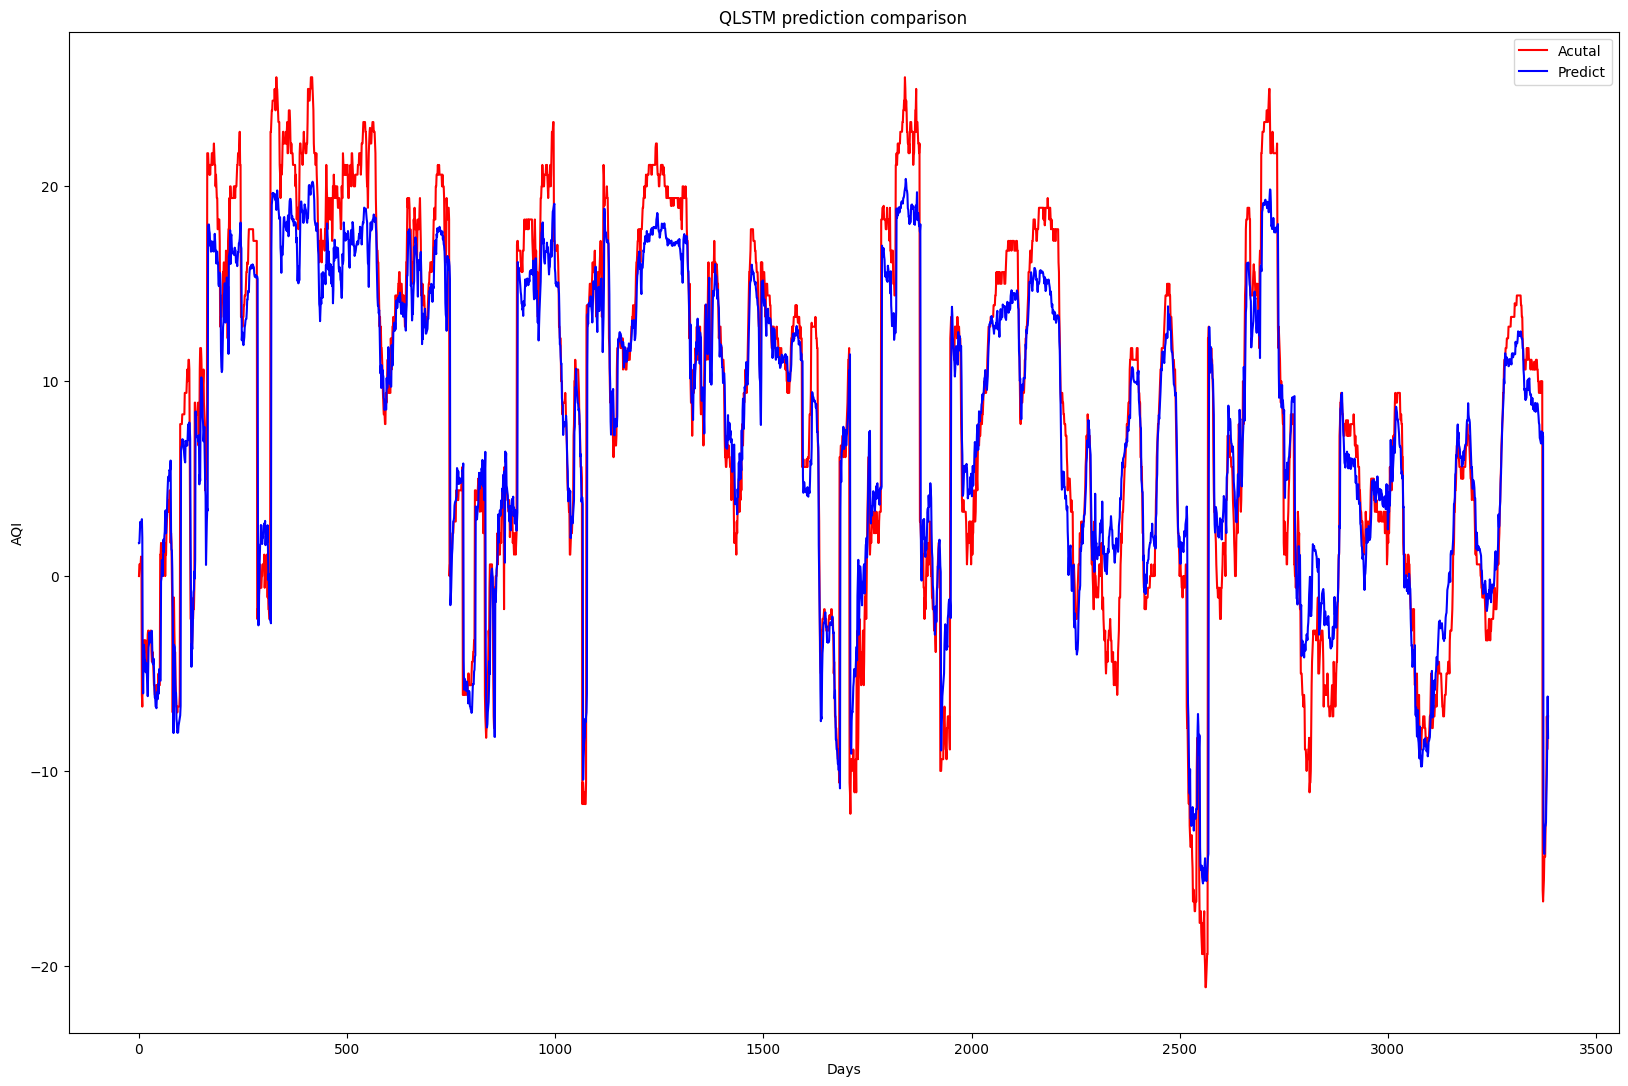

In [26]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:3.7411069251943148


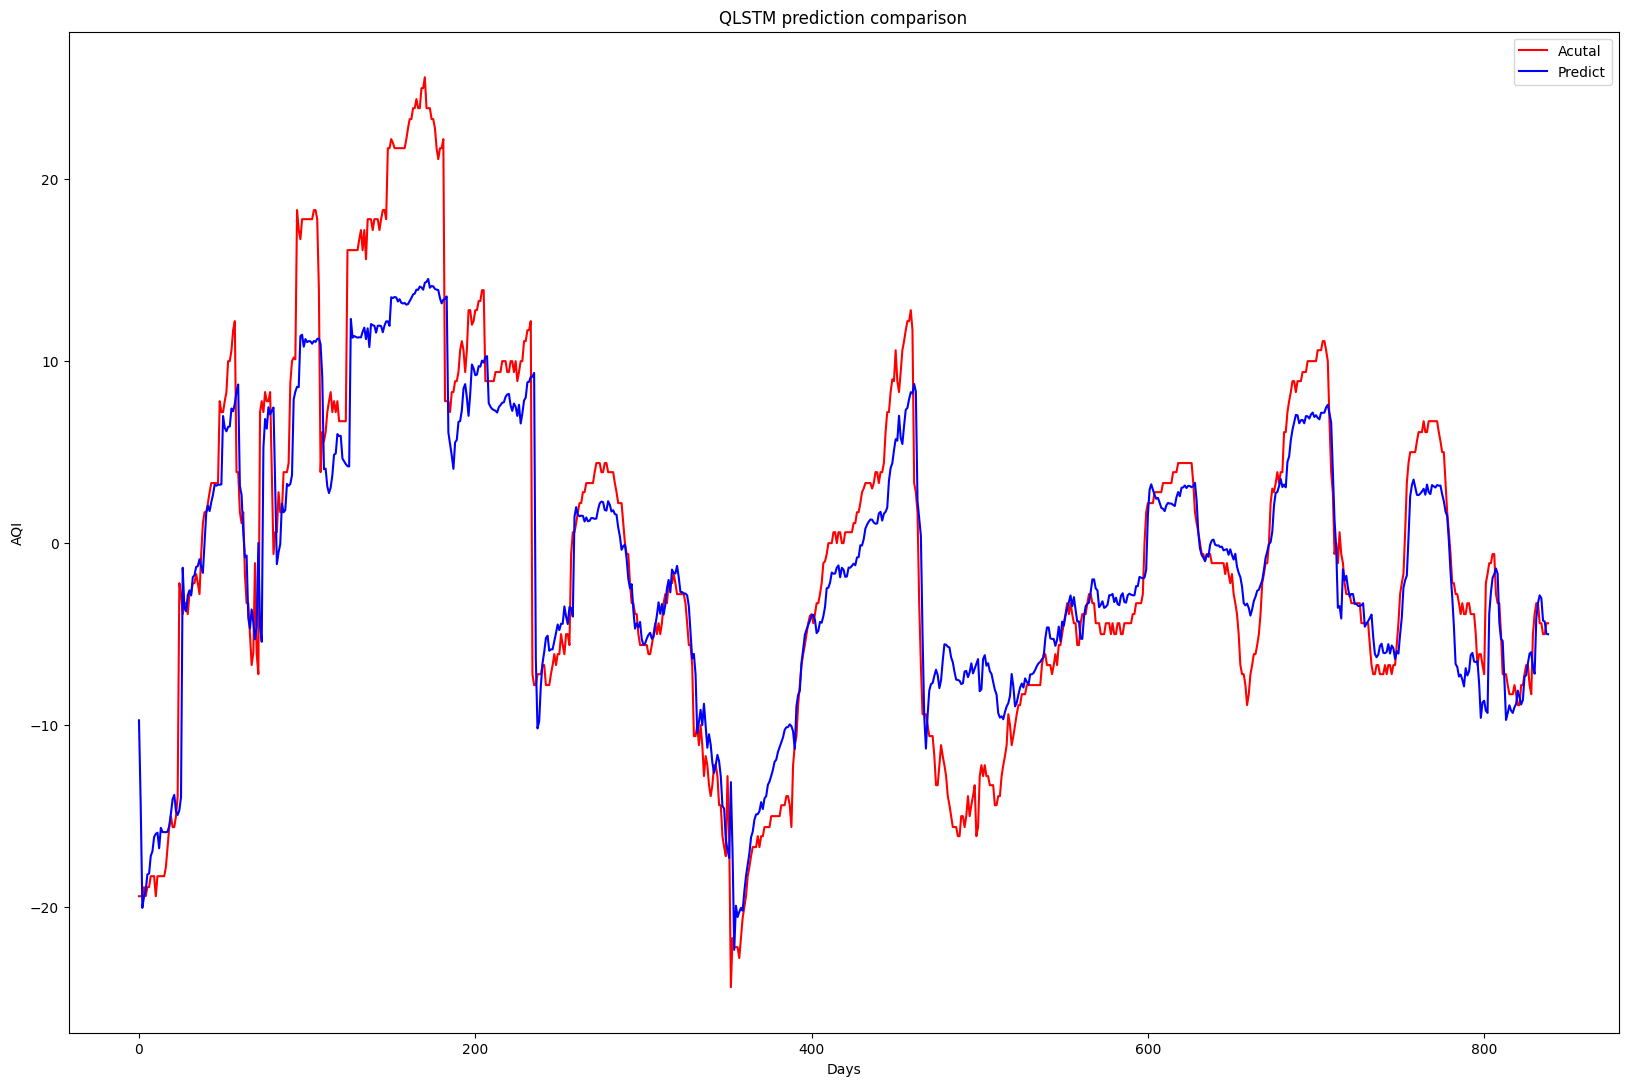

In [27]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [29]:
torch.save(modelQ,'./SavedModels/NY/model/CBLSTM_aqi')